In [3]:
import numpy as np
from scipy.signal import get_window
import matplotlib.pyplot as plt

In [4]:

def read_irregularity_file(filename):
    data = np.genfromtxt(
        filename,
        delimiter=",",
        skip_header=4
    )

    s = data[:, 0]
    u = data[:, 1]

    return s, u


s_high, u_z_high = read_irregularity_file(r"C:\Users\prife\OneDrive - KTH\KTH\04 Research\01 Conferences\2026\Railways\01 Simulations\main_model\output\S7_IRREG1_K1-G_Stuttgart_Ulm.E_Vertical.txt")
s_low, u_z_low = read_irregularity_file(r"C:\Users\prife\OneDrive - KTH\KTH\04 Research\01 Conferences\2026\Railways\01 Simulations\main_model\output\S11_IRREG2_K1-G_Rathenow_Oebisfelde.E_Vertical.txt")

In [5]:
def spatial_amplitude_spectrum(u, dx, window_length_m, overlap):
    # --- sampling ---
    fs_space = 1.0 / dx  # samples per meter
    window_length_samples = int(window_length_m / dx)
    hop = int(window_length_samples * (1 - overlap))

    window = get_window("hann", window_length_samples, fftbins=True)
    window_sum = np.sum(window)

    if window_sum <= 0:
        raise ValueError("Invalid window normalization")

    spectra = []

    for start in range(0, len(u) - window_length_samples + 1, hop):
        segment = u[start:start + window_length_samples]

        # safety checks
        if segment.shape[0] != window_length_samples:
            continue
        if not np.all(np.isfinite(segment)):
            continue

        # remove DC
        segment = segment - np.mean(segment)

        # windowing
        segment = segment * window

        # FFT
        fft_vals = np.fft.rfft(segment)
        amp = np.abs(fft_vals) * 2.0 / window_sum

        spectra.append(amp)

    spectra = np.vstack(spectra)

    # average spectrum
    amp_avg = np.mean(spectra, axis=0)

    # spatial frequency axis
    freq_space = np.fft.rfftfreq(window_length_samples, d=dx)

    return freq_space, amp_avg

In [6]:
# spatial sampling
dx = 0.16  # meters
fs_space = 1.0 / dx  # samples per meter

window_length_m = 100.0
window_length_samples = int(window_length_m / dx)

overlap = 0.25
hop = int(window_length_samples * (1 - overlap))

window = get_window("hann", window_length_samples, fftbins=True)

freq_high, amp_high = spatial_amplitude_spectrum(
    u_z_high,
    dx=dx,
    window_length_m=window_length_m,
    overlap=overlap
)

freq_low, amp_low = spatial_amplitude_spectrum(
    u_z_low,
    dx=dx,
    window_length_m=window_length_m,
    overlap=overlap
)

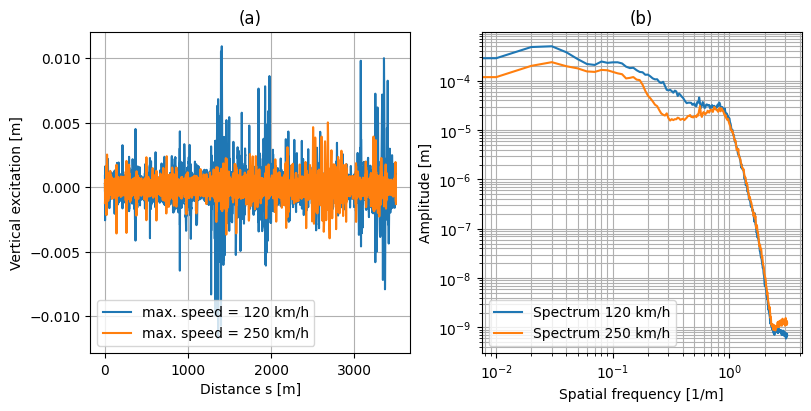

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

# --- Top plot: track profiles ---
axs[0].plot(s_high, u_z_high, label="max. speed = 120 km/h")
axs[0].plot(s_low, u_z_low, label="max. speed = 250 km/h")
axs[0].set_xlabel("Distance s [m]")
axs[0].set_ylabel("Vertical excitation [m]")
axs[0].set_title("(a)")
axs[0].grid(True, which="both")
axs[0].legend()

# --- Bottom plot: amplitude spectra ---
axs[1].loglog(freq_high, amp_high, label="Spectrum 120 km/h")
axs[1].loglog(freq_low, amp_low, label="Spectrum 250 km/h")
axs[1].set_xlabel("Spatial frequency [1/m]")
axs[1].set_ylabel("Amplitude [m]")
axs[1].set_title("(b)")
axs[1].grid(True, which="both")
axs[1].legend()

plt.show()

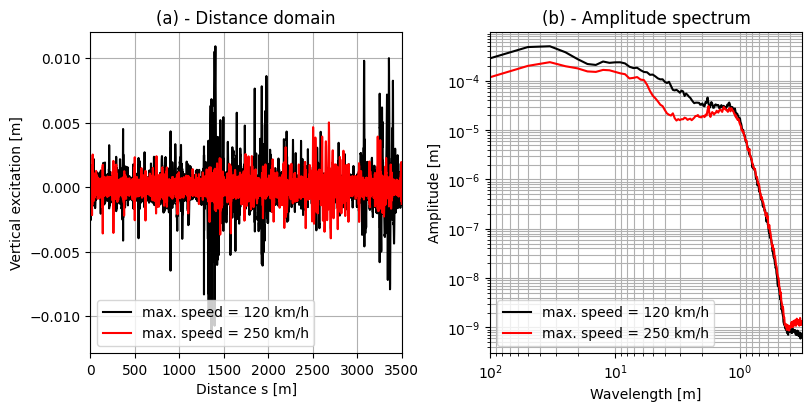

In [11]:
wavelength_high = 1.0 / freq_high[1:]  # skip DC
amp_high_noDC = amp_high[1:]

fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

# --- Top plot: track profiles ---
axs[0].plot(s_high, u_z_high, color="black", label="max. speed = 120 km/h")
axs[0].plot(s_low, u_z_low, color="red", label="max. speed = 250 km/h")

axs[0].set_xlim(
    min(s_high[0], s_low[0]),
    max(s_high[-1], s_low[-1])
)

axs[0].set_xlabel("Distance s [m]")
axs[0].set_ylabel("Vertical excitation [m]")
axs[0].set_title("(a) - Distance domain")
axs[0].grid(True, which="both")
axs[0].legend()

# --- Bottom plot: amplitude spectra ---
axs[1].loglog(wavelength_high, amp_high_noDC, color="black", label="max. speed = 120 km/h")
axs[1].loglog(1.0 / freq_low[1:], amp_low[1:], color="red", label="max. speed = 250 km/h")

# Clip exactly to data range (log-safe)
xmin = min(wavelength_high.min(), (1.0 / freq_low[1:]).min())
xmax = max(wavelength_high.max(), (1.0 / freq_low[1:]).max())
axs[1].set_xlim(xmax, xmin)  # reversed for long wavelengths on the right

axs[1].set_xlabel("Wavelength [m]")
axs[1].set_ylabel("Amplitude [m]")
axs[1].set_title("(b) - Amplitude spectrum")
axs[1].grid(True, which="both")
axs[1].legend()

plt.show()